<a href="https://colab.research.google.com/github/HENUAsshole69/mrnet_injury_detection/blob/master/my_mrnet_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp 'drive/My Drive/MRNet-v1.0.zip' .
!unzip MRNet-v1.0.zip

Archive:  MRNet-v1.0.zip
warning [MRNet-v1.0.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
   creating: MRNet-v1.0/
  inflating: MRNet-v1.0/valid-abnormal.csv  
   creating: MRNet-v1.0/valid/
   creating: MRNet-v1.0/valid/axial/
  inflating: MRNet-v1.0/valid/axial/1139.npy  
  inflating: MRNet-v1.0/valid/axial/1138.npy  
  inflating: MRNet-v1.0/valid/axial/1249.npy  
  inflating: MRNet-v1.0/valid/axial/1248.npy  
  inflating: MRNet-v1.0/valid/axial/1207.npy  
  inflating: MRNet-v1.0/valid/axial/1213.npy  
  inflating: MRNet-v1.0/valid/axial/1171.npy  
  inflating: MRNet-v1.0/valid/axial/1165.npy  
  inflating: MRNet-v1.0/valid/axial/1159.npy  
  inflating: MRNet-v1.0/valid/axial/1158.npy  
  inflating: MRNet-v1.0/valid/axial/1164.npy  
  inflating: MRNet-v1.0/valid/axial/1170.npy  
  inflating: MRNet-v1.0/valid/axial/1212.npy  
  inflating: MRNet-

In [2]:
mv MRNet-v1.0 data

MRI每一个样本含不同数量的切片*(slice)*，由于MRI的切片数量不等，只能将特征提取和分类分离，首先对于单一切片，通过VGG16得到**7x7x512**的特征向量，然后AveragePooling 得到**1x512**的向量，接下来对于一个样本设切片数量为**s**, 通过

```
np.stack(slices_feature_list,axis=0)
```
得到**sx1x512**的向量，通过MaxPooling得到一个**1x512**的特征向量，通过全连接的classifier，得到结果

*下面是所有实现*

从斯坦福的MRNet读入数据的有关函数，数据以npy形式提供，维度为**Sx256x256**,S为切片数量，每个切片为256x256的灰度图片

In [3]:
import cv2
import numpy as np
import re
import csv
from os import listdir
from os.path import isfile, join
import tensorflow as tf

def data_reader(path, label_csv):
    def get_label_from_pic_index(labels, iii):
      for pic in labels:
          if pic[0] == iii:
          
              return int(pic[1])
      raise ValueError("Cannot find "+str(iii))
    label_csv_obj = csv.reader(open(label_csv))
    img_list = []
    label_list =  []
    files = [f for f in listdir(path) if isfile(join(path, f)) and re.match('.*\\.npy', f)]
    for file in files:
        label_csv_obj = csv.reader(open(label_csv))
        index = re.match('(.*)\\.npy', file).group(1)
        label_list.append(get_label_from_pic_index(label_csv_obj, index))
        img_list.append(np.load(path + '/' + file))
    return np.array(img_list), np.array(label_list)


下面是特征提取类，使用keras内置的VGG16，追加PoolingLayer，冻结VGG，PoolingLayer无可训练参数，所以此部分无需训练，另独立添加MaxPooling。**extract**方法首先将样本的每一切片输入，得到特征集合，紧接着将此集合进行MaxPooling

In [4]:
import keras
from keras import Input
from keras.applications.vgg16 import VGG16
from numpy import ndarray
import numpy as np


class FeatureExtractor:
    def __init__(self):
        self.extractor_model = keras.models.Sequential()
        vgg16 = VGG16(include_top=False, input_shape=(3, 256, 256))
        vgg16.trainable = False
        self.extractor_model.add(vgg16)
        self.extractor_model.add(keras.layers.GlobalAveragePooling2D())
        self.extractor_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                                     loss='binary_crossentropy',
                                     metrics=['accuracy'])

    def extract(self, img: ndarray):
        self.init_max_pooling()
        features = []
        for i in range(img.shape[0]):
            sli = img[i]
            features.append(self.extractor_model.predict(np.expand_dims(np.stack((sli,) * 3, axis=0), axis=0)))
        features = np.stack(features, axis=0)
        features = np.transpose(features, axes=(1, 0, 2))
        return self.feature_max_pooling.predict(features)

    def init_max_pooling(self):
        self.feature_max_pooling = keras.models.Sequential()
        self.feature_max_pooling.add(keras.layers.GlobalMaxPooling1D())
        self.feature_max_pooling.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                                         loss='binary_crossentropy',
                                         metrics=['accuracy'])


Using TensorFlow backend.


此处进行train数据的特征提取，针对低val_accuracy,准备在此处进行data augmentation,随机缩放，旋转等。

In [6]:
import keras
from keras import Input
from keras.applications.vgg16 import VGG16
import numpy as np
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

keras.backend.set_image_data_format('channels_first')

train_data_path = r'data/train/coronal'
train_label_csv = r'data/train-abnormal.csv'
x_train_features = []
x_train, y_train = data_reader(train_data_path, train_label_csv)
extractor = FeatureExtractor()
i = 0
for img in x_train:
    x_train_features.append(extractor.extract(img))
    print(len(x_train_features))
x_train_features = np.stack(x_train_features, axis=0)

features = x_train_features
labels = y_train


58892288/58889256 [==============================] - 2s 0us/step
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261

此处是valid数据的特征提取

In [7]:
import keras
from keras import Input
from keras.applications.vgg16 import VGG16
import numpy as np
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

keras.backend.set_image_data_format('channels_first')

val_data_path = r'data/valid/coronal'
val_label_csv = r'data/valid-abnormal.csv'

x_val, y_val = data_reader(val_data_path, val_label_csv)
x_val_features = []
extractor = FeatureExtractor()
i = 0
for img in x_val:
    x_val_features.append(extractor.extract(img))
    print(len(x_val_features))
x_val_features = np.stack(x_val_features, axis=0)

val_features = x_val_features
val_labels = y_val

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


fit history 出图

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

classifier训练，为提高accuracy，准备在此增加learning rate scheduler

In [15]:
def train_classifier(x_train, y_train,x_val,y_val):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    plot_history(model.fit(np.squeeze(x_train), keras.utils.to_categorical(y_train), 50, 14 #10个epoch，再增加epoch会开始overfit,貌似与随机数种子有一定关系，val_accuracy在80%左右
                           , validation_data=(np.squeeze(x_val), keras.utils.to_categorical(y_val))))

Train on 1130 samples, validate on 120 samples
Epoch 1/14
1130/1130 [==============================] - 0s 158us/step - loss: 1.5336 - accuracy: 0.7903 - val_loss: 0.9621 - val_accuracy: 0.6500
Epoch 2/14
1130/1130 [==============================] - 0s 63us/step - loss: 0.7687 - accuracy: 0.6938 - val_loss: 0.7952 - val_accuracy: 0.7000
Epoch 3/14
1130/1130 [==============================] - 0s 68us/step - loss: 0.6136 - accuracy: 0.7575 - val_loss: 0.7139 - val_accuracy: 0.7167
Epoch 4/14
1130/1130 [==============================] - 0s 64us/step - loss: 0.5440 - accuracy: 0.7832 - val_loss: 0.6429 - val_accuracy: 0.7250
Epoch 5/14
1130/1130 [==============================] - 0s 63us/step - loss: 0.5038 - accuracy: 0.7956 - val_loss: 0.6109 - val_accuracy: 0.7500
Epoch 6/14
1130/1130 [==============================] - 0s 65us/step - loss: 0.4738 - accuracy: 0.8097 - val_loss: 0.5927 - val_accuracy: 0.7500
Epoch 7/14
1130/1130 [==============================] - 0s 64us/step - loss: 0.452

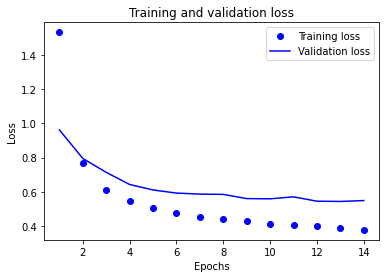

In [16]:
train_classifier(features,labels,val_features,val_labels)